In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import urllib.parse

### 1. Separate data into training, validation and test sets

In [2]:
data = pd.read_json('data/image_labels.json.bz2', compression='bz2')
shape_before = data.shape
print(shape_before)
# Make sure all images have '/commons/' in their path, otherwise they apparently aren't in the WIT_Dataset
data = data[data.image_url.str.contains('/commons/')]
print(f'Images without /commons/ on their path that were removed: {shape_before[0] - data.shape[0]}')

# After /commons/ comes the file location as it is organized in the WIT_dataset, so take it:
data['image_paths'] = [url.split('commons/')[1] for url in data.image_url]

# Decode filename paths so they are validated by tensorflow later
data['image_paths'] = data['image_paths'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename))

# Get test dataframe out of data:
test_indices = np.random.choice(size=(int(0.1 * len(data.index)), ), replace=False, a=data.index)
test_data = data.loc[test_indices, :]
print(f'Test data: {test_data.shape}')

# Remove test indices from train and validation dataframe
train_val_data = data.drop(labels=pd.Series(test_indices), axis=0)
print(f'Train data: {train_val_data.shape}')

(1043449, 5)
Images without /commons/ on their path that were removed: 3060
Test data: (104038, 6)
Train data: (936351, 6)


In [3]:
train_val_data.head()

,image_url,page_url,page_title,title,taxo_labels,image_paths
0,http://upload.wikimedia.org/wikipedia/commons/...,[https://en.wikipedia.org/wiki/Dodge_Colt],[Dodge Colt],[Dodge Colt],"[STEM.STEM*, History and Society.Transportatio...",0/00/'93-'94_Plymouth_Colt_Sedan.jpg
2,http://upload.wikimedia.org/wikipedia/commons/...,[https://en.wikipedia.org/wiki/March_1st_Movem...,[March 1st Movement],[March 1st Movement],"[Geography.Regions.Asia.Asia*, Geography.Regio...",0/00/(Red_Cross_pamphlet_on_March_1st_Movement...
3,http://upload.wikimedia.org/wikipedia/commons/...,[https://fr.wikipedia.org/wiki/Lozay],[Lozay],[Lozay],"[Geography.Regions.Europe.Western Europe, Geog...",0/00/Église_de_Lozay.jpg
4,http://upload.wikimedia.org/wikipedia/commons/...,[https://pt.wikipedia.org/wiki/%C3%9Ahonice],[Úhonice],[Úhonice],"[Geography.Regions.Europe.Eastern Europe, Geog...","0/00/Úhonice,_church_2.jpg"
5,http://upload.wikimedia.org/wikipedia/commons/...,[https://de.wikipedia.org/wiki/Reykjav%C3%ADk],[Reykjavík],[Reykjavík],"[Geography.Geographical, Geography.Regions.Eur...",0/00/Þjóðmenningarhús01.jpg


Divide dataset into train and validation sets

In [4]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_DIMENSION = 64

# Data generator for training and validation sets, performs data augmentations
train_val_generator = ImageDataGenerator(validation_split=0.10, 
                                         rescale=1/255, # rescale inputs so that they are between 0 and 1, and not 0 and 255
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest') 
train = train_val_generator.flow_from_dataframe(dataframe=train_val_data, 
                                                directory='/scratch/WIT_Dataset/images', 
                                                x_col='image_paths', 
                                                y_col='taxo_labels', 
                                                class_mode='categorical',
                                                subset='training',
                                                validate_filenames=True,
                                                target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION)) # the dimensions to which all images found will be resized.
                                            
val = train_val_generator.flow_from_dataframe(dataframe=train_val_data, 
                                              directory='/scratch/WIT_Dataset/images', 
                                              x_col='image_paths', 
                                              y_col='taxo_labels', 
                                              class_mode='categorical',
                                              subset='validation',
                                              validate_filenames=True,
                                              target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

# Data generator for test set
test_generator = ImageDataGenerator(rescale=1/255) 
test = test_generator.flow_from_dataframe(dataframe=test_data,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='image_paths', 
                                          y_col='taxo_labels', 
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 144738 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  warnings.warn(


Found 712452 validated image filenames belonging to 64 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 144738 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  warnings.warn(


Found 79161 validated image filenames belonging to 64 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 16008 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  warnings.warn(


Found 88030 validated image filenames belonging to 64 classes.


### 2. Construct and train model
Here, we construct a model where the first layers are EfficientNetB0 pre-trained on ImageNet-1k(https://keras.io/api/applications/efficientnet/) with added layers to the end, and train these final end layers with our training data.

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Take efficientnet pre-trained on imagenet-1k, not including the last layer 
N_CLASSES = 64
efficient_net = EfficientNetB0(include_top=False, 
                               weights='imagenet', 
                               input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3), # to be specified if include_top is False.
                               classes=N_CLASSES,
                               )
efficient_net.trainable = False

In [6]:
# Add a final layer with the same number of neurons as there are classes and train only weights of this layer, i.e. transfer learning!
model = Sequential()
model.add(efficient_net)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=N_CLASSES, activation='sigmoid')) # output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 120)               614520    
                                                                 
 dense_1 (Dense)             (None, 64)                7744      
                                                                 
Total params: 4,671,835
Trainable params: 622,264
Non-trainable params: 4,049,571
_________________________________________________________________


Compile model

In [7]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), 
              loss='binary_crossentropy', # on what loss function to choose: https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary
              metrics=['accuracy']
              ) 

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train model

In [8]:
epochs = 50
history = model.fit(train, 
                    epochs=50, 
                    steps_per_epoch=15, 
                    validation_data=val,
                    validation_steps=7
                    )

Epoch 1/50
15/15 [==============================] - 15s 657ms/step - loss: 0.5681 - accuracy: 0.0042 - val_loss: 0.4731 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 9s 571ms/step - loss: 0.4291 - accuracy: 0.0146 - val_loss: 0.3655 - val_accuracy: 0.0179
Epoch 3/50
15/15 [==============================] - 8s 563ms/step - loss: 0.3251 - accuracy: 0.0125 - val_loss: 0.2755 - val_accuracy: 0.0045
Epoch 4/50
15/15 [==============================] - 8s 553ms/step - loss: 0.2598 - accuracy: 0.0083 - val_loss: 0.2146 - val_accuracy: 0.0045
Epoch 5/50
15/15 [==============================] - 9s 646ms/step - loss: 0.2135 - accuracy: 0.0083 - val_loss: 0.1852 - val_accuracy: 0.0089
Epoch 6/50
15/15 [==============================] - 8s 549ms/step - loss: 0.1867 - accuracy: 0.0167 - val_loss: 0.1754 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 8s 553ms/step - loss: 0.1782 - accuracy: 0.0146 - val_loss: 0.1605 - val_accuracy: 0.00

/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 9s 629ms/step - loss: 0.1498 - accuracy: 0.1604 - val_loss: 0.1356 - val_accuracy: 0.2500
Epoch 42/50
15/15 [==============================] - 9s 577ms/step - loss: 0.1489 - accuracy: 0.1750 - val_loss: 0.1437 - val_accuracy: 0.2634
Epoch 43/50
15/15 [==============================] - 9s 579ms/step - loss: 0.1452 - accuracy: 0.1417 - val_loss: 0.1428 - val_accuracy: 0.2634
Epoch 44/50
15/15 [==============================] - 8s 518ms/step - loss: 0.1485 - accuracy: 0.1479 - val_loss: 0.1331 - val_accuracy: 0.3438
Epoch 45/50
15/15 [==============================] - 9s 588ms/step - loss: 0.1478 - accuracy: 0.1479 - val_loss: 0.1398 - val_accuracy: 0.2991
Epoch 46/50
15/15 [==============================] - 9s 603ms/step - loss: 0.1450 - accuracy: 0.1396 - val_loss: 0.1471 - val_accuracy: 0.2768
Epoch 47/50
15/15 [==============================] - 9s 583ms/step - loss: 0.1462 - accuracy: 0.1437 - val_loss: 0.1323 - val_accuracy: 0.2902
Epoch 48/50

Plot training vs validation accuracy and loss

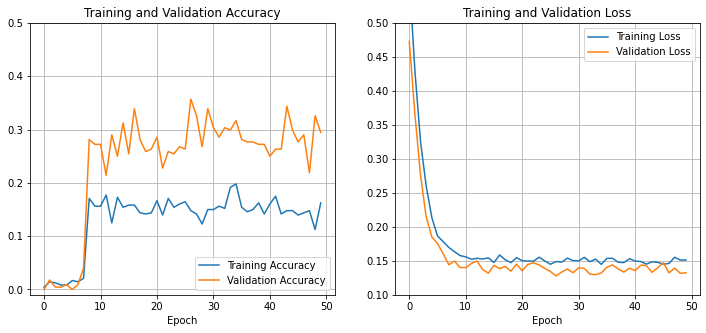

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylim(-0.01, 0.5)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylim(0.1, 0.5)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Evaluation metrics
Here, we evaluate the trained model on the test set and take out classification metrics (precision & recall) for each of the individual 64 classes.

In [10]:
test_accuracy_score = model.evaluate(test)
print(test_accuracy_score)
print("Accuracy: {:.4f}%".format(test_accuracy_score[1] * 100)) 
print("Loss: ", test_accuracy_score[0])

2751/2751 [==============================] - 881s 320ms/step - loss: 0.1479 - accuracy: 0.1657
[0.14788179099559784, 0.1657162308692932]
Accuracy: 16.5716%
Loss:  0.14788179099559784


In [11]:
predictions = model.predict(test)
print(predictions.shape)
threshold = 0.1
y_pred = 1 * (predictions > threshold)

(88030, 64)


In [12]:
# Transform 'test.classes' to a one-hot encoded matrix, y_true
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

Checking for data imbalance

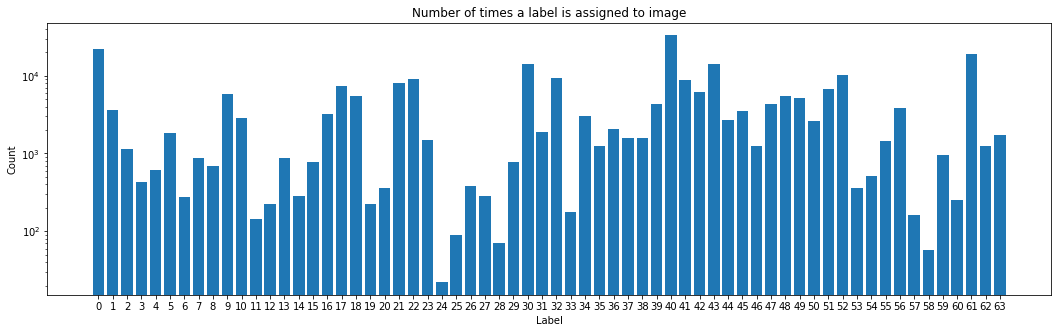

In [13]:
from matplotlib import pyplot as plt 

_ = plt.figure(figsize=(18, 5))
_ = plt.title('Number of times a label is assigned to image')
_ = plt.xlabel('Label')
_ = plt.ylabel('Count')
_ = plt.yscale('log')
_ = plt.xticks(range(y_true.shape[1]), range(y_true.shape[1]), fontsize=10)
_ = plt.bar(test.class_indices.keys(), np.sum(y_true, axis=0))

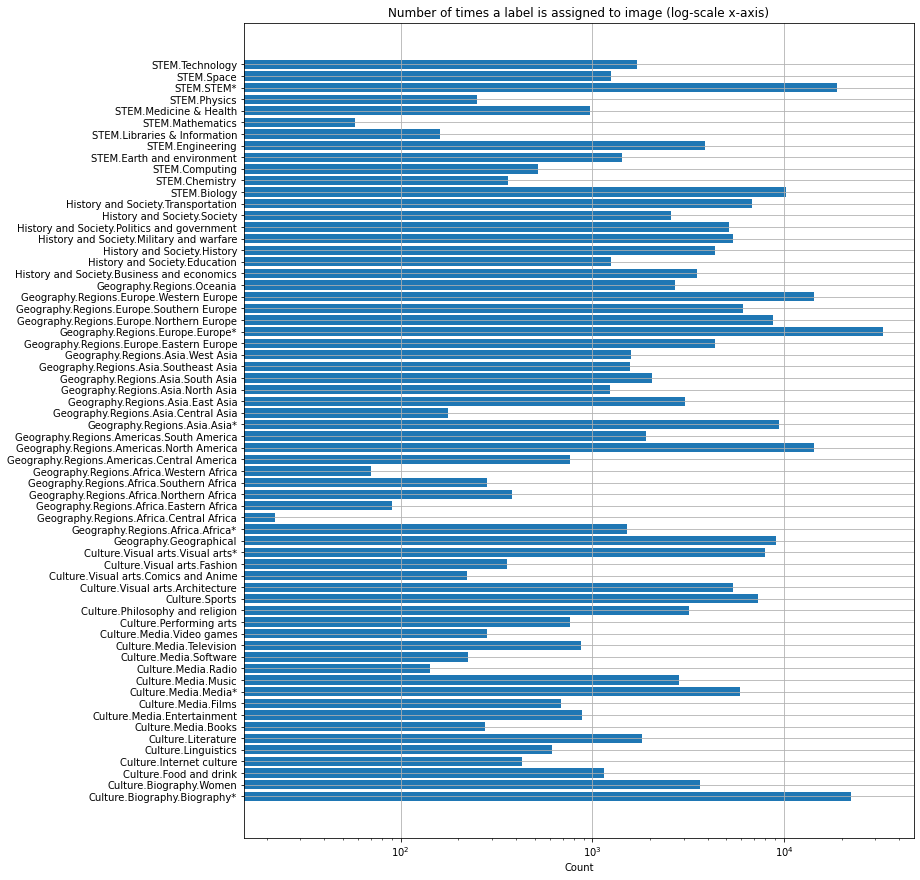

In [14]:
_ = plt.figure(figsize=(12, 15))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')
_ = plt.barh(range(y_true.shape[1]), np.sum(y_true, axis=0))
_ = plt.yticks(range(y_true.shape[1]), list(test.class_indices.keys()))
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.grid(True)

Make predictions on the test set and then get classification metrics

In [15]:
from sklearn.metrics import classification_report

metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
metrics_df.tail(4)

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,index
micro avg,0.211802,0.442265,0.286431,252973.0,None
macro avg,0.022172,0.093762,0.032040,252973.0,None
weighted avg,0.115285,0.442265,0.171513,252973.0,None
samples avg,0.211804,0.474705,0.279777,252973.0,None


Precision & recall metrics for each class

<ipython-input-16-a181c9d4aaec>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
<ipython-input-16-a181c9d4aaec>:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))


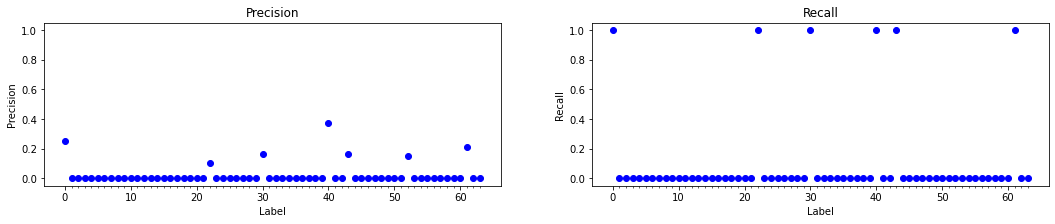

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall')
axs[0].set_ylim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
axs[0].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[1].set_xticks(range(y_true.shape[1]), range(y_true.shape[1]))
axs[0].plot(range(y_true.shape[1]), metrics_df.precision[0:64], 'bo')
axs[1].plot(range(y_true.shape[1]), metrics_df.recall[0:64], 'bo')